In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this notebook, we will explore an object classification task similar to an application deployed by John Deere in agricultural machines across the world.

This task will involve using a pre-trained Convolutional Neural Network (CNN) to classify images of plants into weeds or regular plants so that farmers can more efficiently spray herbicides, which reduces their costs and is good for the environment.]

You can see one example of how this is used in practice here: https://youtu.be/65_71XYsO64?t=88


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/my_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/drive/MyDrive/my_data/Docknet/train/docks/8837_2464_9441.jpg
/content/drive/MyDrive/my_data/Docknet/train/notdocks/32454_8877_15545.jpg
/content/drive/MyDrive/my_data/Docknet/valid/docks/31_26934_24239.jpg
/content/drive/MyDrive/my_data/Docknet/valid/notdocks/809_27910_9024.jpg


In [ ]:
# Specifies the path where our training and validation data are
# Inside our training and validation folders, we can put each image into a subfolder with the name of its class
# and Tensorflow will automatically set their labels.
# We have the class dock (weed) and not dock (good)
# This is the species of weed we are detecting: https://en.wikipedia.org/wiki/Rumex

train_dir = os.path.join("/content/drive/MyDrive/my_data/Docknet/train")
validation_dir = os.path.join("/content/drive/MyDrive/my_data/Docknet/valid")

# We need to specify how many images our neural network will process at each training step. In this case, it will look at 32 images per step.
# This influences the performance of the network but it's usually defined with respect to the available GPU memory
# Higher numbers = faster steps, but it may take more steps to converge to a stable/good solution
BATCH_SIZE = 32

# Specifying the size we want our images to be. Tensorflow resizes it automatically.
# Higher dimensions = harder to train, requires larger neural networks and more samples
IMG_SIZE = (128, 128)

# This function will load and label the samples
# Shuffle = true is important because neural networks can only see one step (batch) at a time.
# This makes them sensitive to the sorting of the data and can hurt the training process.
# Shuffling the data solves this problem.
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2361 files belonging to 2 classes.
Found 680 files belonging to 2 classes.


The images are loaded and converted into tensors (matrices with 3+ dimensions for our practical purposes)

Their shape will be (128,128,3) which include the horizontal and vertical dimensions plus 3 RGB dimensions.

For practical purposes, you can think about this just as mixing paints. They are 3 matrices of pixel intensities. One for how much red, another for how much green and the other for how much blue we should mix at each pixel to get the image.

Later we will add another dimension, which will account for the batch size. So for a batch of 32 images, our tensor will be (32, 128, 128, 3). Simply 32 images of 128 x 128 whose pixels are a mix of 3 colors.

Let's take a look at a few samples from the dock and nondock class.

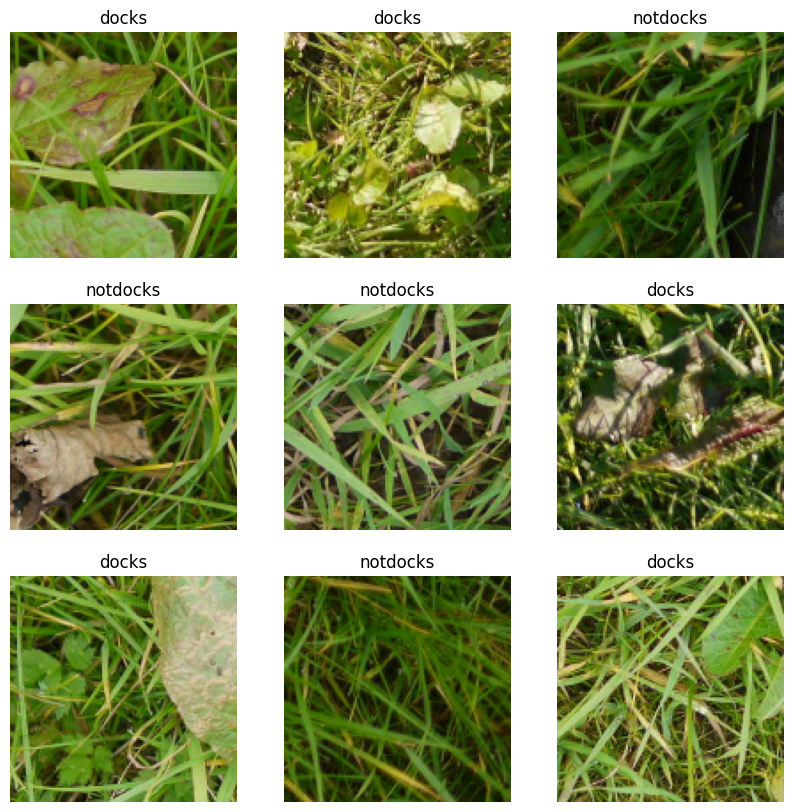

In [ ]:
# Classes are docks (0), notdocks (1)
class_names = train_dataset.class_names


plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1): # takes one batch of images, let's see the first 9
    #print(images.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Some of the images are clearly different, but a few have docks that grew in the middle of other plants and can be a challenge for our model.

In [ ]:
# GPUs are very fast for matrix computations, so we don't want the input/output of images to be a bottleneck.
# Prefetching with AUTOTUNE will help Tensorflow find the optimal way to load the images so that our GPU always has data to work on.
# More info: https://www.tensorflow.org/guide/data_performance#prefetching
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation
- We don't want our model to break when we show the same image, but flipped, so we artifically augment the data to make the model robust

In [ ]:
# A neural network is a sequence of matrix operations. Keras has a very simple API to help us assemble the building blocks to create our networks.
# It's called the Sequential API
# We can pass a list of layers to this object and it will connect everything for us to have a functional neural network.
data_augmentation = tf.keras.Sequential([

  # There are many creative ways to randomize our data and make our models more robust. Here we will use two:
  # RandomFlip: This layer will flip the images horizontally and or vertically based on the mode attribute. During inference time, the output will be identical to input. Call the layer with training=True to flip the input.
  tf.keras.layers.RandomFlip('horizontal'),
  # RandomRotation: This layer will apply random rotations to each image. Factor here is a float represented as fraction of 2 Pi.
  tf.keras.layers.RandomRotation(factor=0.2),
])

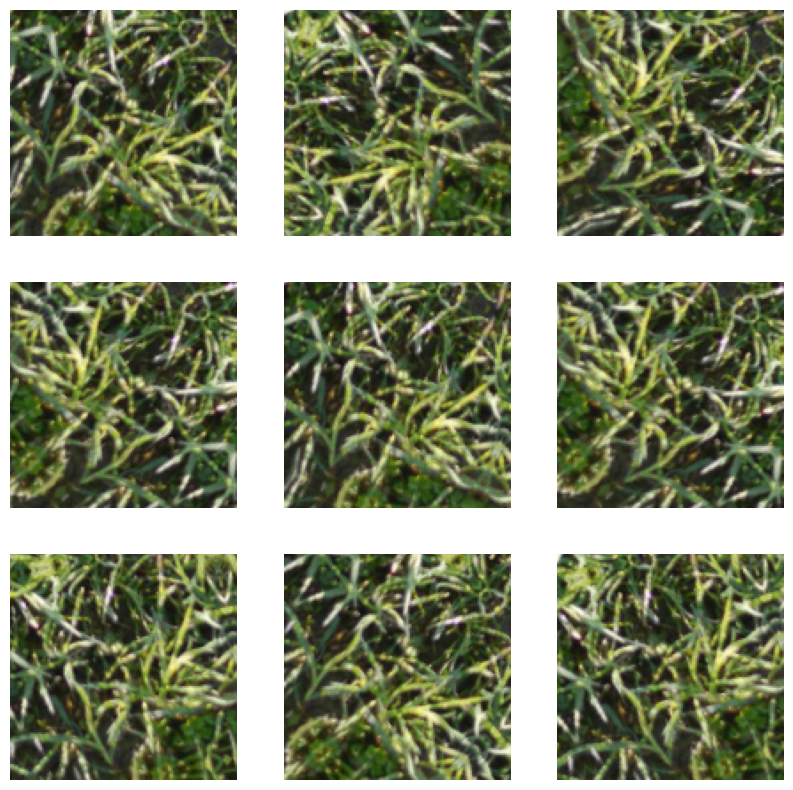

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # The building blocks are made to deal with batches of images, even if the batch contains only one image,
        # so here we need to use the tf.expand_dims functions to add the "batch size" dimension to our tensor
        # Instead of a tensor of (128,128,3), we need to feed a tensor of (1,128,128,3) to the function.
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Transfer Learning

Neural networks are extremely data-hungry, but instead of learning all our filters from scratch, we can start from filters learned over huge datasets

I like to think of it as similar to this screwdriver: https://www.amazon.com/Amartisan-Multi-bit-Screwdriver-Portable-Multi-Purpose/dp/B097HN6L2B

The body of the tool can be reused, we just change the tip according to what we need to do.

In the same way, we will reuse a huge neural networks that was trained in a huge dataset, just changing the last layers.

This works because the neural networks learns how to scan an image for patterns during training. And it turns out many of these "filters" are valid for any type of image, so we don't need to learn them from scratch every time.

In [ ]:
# You can see all the pretrained models that are available on Keras here: https://keras.io/api/applications/

# We will start with MobileNetV2 which is a convolutional neural network optimized to run in mobile devices with accuracy closer to bigger models.
# Your phone comes with a few neural networks installed to run without needing to connect to the cloud, some are likely similar to this one.
# This line takes the preprocessing function that was used on the original training and makes it available for us to use in our images,
# so we can fit them to the requirements of the pretrained network

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# We need to specify the image size, with the 3 RGB channels for the Keras object that will return the pretrained network
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # don't include the original last layer, as we want to use our own layer
                                               weights='imagenet') # specify which version of the network we want,
                                                                   # this is one trained on the ImageNet dataset,
                                                                   # usually we want NNs that were trained in a dataset similar to ours


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# We need to tell keras to NOT train the original network. If we don't specify it, it will try to train all the weights.
# There are situations in which we can "fine-tune" the original weights. Here we just want these weights are feature extractors.
base_model.trainable = False

In [ ]:
# This function shows the full neural network structure.
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

In [ ]:
# The simplest (but very powerful way) to use this network with new data is by averaging each of the convolutional filters of the current last layer
# and using it as features to the output layer.
# Above you can see the out_relu layer has dimension (None, 4, 4, 1280)
# None is a placeholder for the batch size
# 4 x 4 are the sizes of the filter outputs
# 1280 is the number of filters it learned (pre-specified as a hyperparameter)
# For each of these 1280 filters, the GlobalAveragePooling2D layer will take the average of the 16 (4x4) numbers
# Then it passes it to the output layer, which in this case is very similar to doing a logistic regression over a 1280-sized vector

global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D, average of the 4x4 (16) values of each filter output
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')


# Let's put everything together
# This is another way to assemble the building blocks of a neural network in Keras. It's called the Functional API
# We always indicate the previous layer by calling it on the next layer

# Specifies the input shape (it doesn't take the batch size, as it will have None as placeholder)
inputs = tf.keras.Input(shape=(128, 128, 3))
# Connects the input layer to our data augmentation sequence of layers
x = data_augmentation(inputs)
# Passes our augmented samples to the original preprocessing functions of the pretrained net
# Currently, for MobileNetV2 in Keras, it will make the pixel range between -1 and 1. This helps the model convergence.
x = preprocess_input(x)
# Send the preprocessed batch of images to the pretrained model
x = base_model(x, training=False)
# Gets the output of the pretrained model and sends it to our global average pooling layer and then the output layer
x = global_average_layer(x)
outputs = prediction_layer(x)


# Tells Keras to create the model object, connecting the input layer all the way to the output
# If some building block has the wrong input size, it will throw an error
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Our final model structure. It collapsed the structure of MobileNetV2, but all those layers are still here
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
# We need to specify how much each step will change our weights. This is done via the learning rate.
# Higher learning rates can make the model converge to a local optima region faster, but they easily make your model diverge (go completely crazy)
# This is a hyperparameter just like you saw during the XGBoost lecture
base_learning_rate = 0.0001

# There are many algorithms to guide the neural network to the optimal weights.
# Adam is one that works very well in practice, but the details are beyond our scope today.
# We specify the loss function as binary cross-entropy, which is the most common binary classification loss function in ML.
# We can monitor multiple metrics in our validation dataset. Let's keep an eye on Accuracy and ROC AUC.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.AUC()])

In [ ]:
# The new layers we introduced to the pretrained net were initialized randomly, so our AUC is closer to 0.5 and the accuracy is very poor.
loss0, accuracy0, auc0 = model.evaluate(validation_dataset) # "random model"

22/22 [==============================] - 15s 473ms/step - loss: 0.9413 - accuracy: 0.3044 - auc_1: 0.6516


In [ ]:
# An epoch is just a fancy name to say we iterated over the full dataset once.
# It's common practice to specify the number of steps we want our neural network for in the epoch format
# We usually set a "big" number of epochs and see at which point our neural network stopped improving or is simply improving too little.
# Then we use it as the final number of training epochs.
initial_epochs = 200

hist1 =model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/200
74/74 [==============================] - 66s 783ms/step - loss: 0.5354 - accuracy: 0.7277 - auc_1: 0.8158 - val_loss: 0.5303 - val_accuracy: 0.7529 - val_auc_1: 0.8120
Epoch 2/200
74/74 [==============================] - 58s 774ms/step - loss: 0.4586 - accuracy: 0.7967 - auc_1: 0.8686 - val_loss: 0.4692 - val_accuracy: 0.8074 - val_auc_1: 0.8529
Epoch 3/200
74/74 [==============================] - 51s 677ms/step - loss: 0.4173 - accuracy: 0.8124 - auc_1: 0.8913 - val_loss: 0.4319 - val_accuracy: 0.8279 - val_auc_1: 0.8674
Epoch 4/200
74/74 [==============================] - 47s 637ms/step - loss: 0.4058 - accuracy: 0.8149 - auc_1: 0.8947 - val_loss: 0.4162 - val_accuracy: 0.8294 - val_auc_1: 0.8749
Epoch 5/200
74/74 [==============================] - 62s 833ms/step - loss: 0.3922 - accuracy: 0.8132 - auc_1: 0.9002 - val_loss: 0.3926 - val_accuracy: 0.8426 - val_auc_1: 0.8802
Epoch 6/200
74/74 [==============================] - 49s 658ms/step - loss: 0.3787 - accuracy: 0.825

In [ ]:
train_results = model.evaluate(train_dataset)
val_results = model.evaluate(validation_dataset)

train_loss = train_results[0]
train_accuracy = train_results[1]

val_loss = val_results[0]
val_accuracy = val_results[1]

print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))
print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))



In [ ]:
model.save('/content/drive/MyDrive/Weeds-Detection-and-Segmentation-master/weed_mobileNet.h5')

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Make predictions on the validation dataset
validation_predictions = model.predict(validation_dataset)
validation_predictions = np.round(validation_predictions).flatten()  # Convert probabilities to binary predictions

# Convert true labels from the validation dataset to a flat array
validation_labels = np.concatenate([y for x, y in validation_dataset], axis=0)

# Create confusion matrix
cm = confusion_matrix(validation_labels, validation_predictions)

print("Confusion Matrix:")
print(cm)


In [ ]:
import matplotlib.pyplot as plt

# Retrieve accuracy values from the history object
accuracy = hist1.history['accuracy']
val_accuracy = hist1.history['val_accuracy']

# Plot the accuracy curve
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Retrieve loss values from the history object
loss = hist1.history['loss']
val_loss = hist1.history['val_loss']

# Plot the loss curve
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Make predictions on the validation dataset
validation_predictions = model.predict(validation_dataset)

# Convert true labels from the validation dataset to a flat array
validation_labels = np.concatenate([y for x, y in validation_dataset], axis=0)

# Compute false positive rate (FPR), true positive rate (TPR), and threshold values
fpr, tpr, thresholds = roc_curve(validation_labels, validation_predictions)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Make predictions on the training dataset
train_predictions = model.predict(train_dataset)

# Make predictions on the validation dataset
validation_predictions = model.predict(validation_dataset)

# Convert true labels from the training and validation datasets to flat arrays
train_labels = np.concatenate([y for x, y in train_dataset], axis=0)
validation_labels = np.concatenate([y for x, y in validation_dataset], axis=0)

# Compute false positive rate (FPR), true positive rate (TPR), and threshold values for training data
fpr_train, tpr_train, thresholds_train = roc_curve(train_labels, train_predictions)

# Compute false positive rate (FPR), true positive rate (TPR), and threshold values for validation data
fpr_val, tpr_val, thresholds_val = roc_curve(validation_labels, validation_predictions)

# Compute the area under the ROC curve (AUC) for training and validation data
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_val = auc(fpr_val, tpr_val)

# Plot the ROC curve for training and validation data
plt.figure()
plt.plot(fpr_train, tpr_train, label='Training ROC curve (AUC = {:.2f})'.format(roc_auc_train))
plt.plot(fpr_val, tpr_val, label='Validation ROC curve (AUC = {:.2f})'.format(roc_auc_val))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# *SVM*






In [ ]:
pip install keras

In [ ]:
pip install keras_utils

In [ ]:
pip install reset_tf_session

In [ ]:
pip install tensorflow.contrib.slim

In [ ]:
import sys
import os
import os
import shutil
import tqdm
import requests
import time
from functools import wraps
import traceback
tqdm.monitor_interval = 0
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cv2  # for image processing
from sklearn.model_selection import train_test_split
import scipy.io
import os
import tarfile
import tqdm
import keras_utils
#from keras_utils import reset_tf_session
import sys
import os
import os
import shutil
import tqdm
import requests
import time
from functools import wraps
import traceback
tqdm.monitor_interval = 0
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import cv2  # for image processing
from sklearn.model_selection import train_test_split
import scipy.io
import os
import tarfile
import tqdm
from __future__ import print_function
import os,time,cv2, sys, math
import tensorflow as tf
#import tensorflow.contrib.slim as slim
import numpy as np
import time, datetime
import argparse
import random
import os, sys
import subprocess
import matplotlib.pyplot as plt
import cv2
import numpy as np
import itertools
import operator
import os, csv
import tensorflow as tf



In [ ]:
from sklearn.svm import SVC
from keras.models import Model
svm = SVC(kernel='rbf', probability=True)
model_feat = Model(inputs=model.input,outputs=model.get_layer('global_average_pooling2d').output)

In [ ]:
# Generate Feature Matrix
model_feat = Model(inputs=model.input,outputs=model.get_layer('global_average_pooling2d').output)
feature_matrix = []
for item in tr_files:
    item = np.reshape(item, [1, item.shape[0], item.shape[1], item.shape[2]])
    feat_train = model_feat.predict(item)
    feature_matrix.append(feat_train)
np.array(feature_matrix)

import pandas as pd
feature_matrix = np.reshape(np.array(feature_matrix), (9840, 2048))
pd.DataFrame(np.array(feature_matrix)).to_csv("features.csv")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Create a CNN model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Print the model summary
cnn_model.summary()


In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Create an SVM classifier with a linear kernel
svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))

# Train the SVM classifier on the training data
train_images, train_labels = next(iter(train_dataset))
train_images = train_images.numpy()
train_labels = train_labels.numpy()
train_images = train_images / 255.0  # Normalize the images

# Flatten the images for SVM input (reshape to 1D array)
train_images = train_images.reshape(train_images.shape[0], -1)

svm_model.fit(train_images, train_labels)

# Evaluate the SVM classifier on the validation data
validation_images, validation_labels = next(iter(validation_dataset))
validation_images = validation_images.numpy()
validation_labels = validation_labels.numpy()
validation_images = validation_images / 255.0  # Normalize the images

# Flatten the images for SVM input (reshape to 1D array)
validation_images = validation_images.reshape(validation_images.shape[0], -1)

svm_accuracy = svm_model.score(validation_images, validation_labels)
print("SVM Accuracy: {:.2f}%".format(svm_accuracy * 100))


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a CNN model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),  # Extract features from here
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the CNN model
cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the CNN model on the training data
train_images, train_labels = next(iter(train_dataset))
train_images = train_images.numpy()
train_labels = train_labels.numpy()
train_images = train_images / 255.0  # Normalize the images

cnn_model.fit(train_images, train_labels, epochs=10)

# Extract features from the CNN model (output of the GlobalAveragePooling2D layer)
train_features = cnn_model.predict(train_images)

# Reshape features for Random Forest input (flatten the 4D array to 2D)
train_features = train_features.reshape(train_features.shape[0], -1)

# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features, train_labels)

# Evaluate the combined CNN + Random Forest classifier on the validation data
validation_images, validation_labels = next(iter(validation_dataset))
validation_images = validation_images.numpy()
validation_labels = validation_labels.numpy()
validation_images = validation_images / 255.0  # Normalize the images

# Extract features from the CNN model for the validation data
validation_features = cnn_model.predict(validation_images)

# Reshape features for Random Forest input (flatten the 4D array to 2D)
validation_features = validation_features.reshape(validation_features.shape[0], -1)

# Make predictions using the Random Forest classifier
rf_predictions = rf_classifier.predict(validation_features)

# Calculate accuracy
rf_accuracy = accuracy_score(validation_labels, rf_predictions)
print("Combined CNN + Random Forest Accuracy: {:.2f}%".format(rf_accuracy * 100))


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create a CNN model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.GlobalAveragePooling2D(),  # Extract features from here
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the CNN model
cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Train the CNN model on the training data
train_images, train_labels = next(iter(train_dataset))
train_images = train_images.numpy()
train_labels = train_labels.numpy()
train_images = train_images / 255.0  # Normalize the images

cnn_model.fit(train_images, train_labels, epochs=10)

# Extract features from the CNN model (output of the GlobalAveragePooling2D layer)
train_features = cnn_model.predict(train_images)

# Reshape features for Decision Tree input (flatten the 4D array to 2D)
train_features = train_features.reshape(train_features.shape[0], -1)

# Create and train the Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(train_features, train_labels)

# Evaluate the combined CNN + Decision Tree classifier on the validation data
validation_images, validation_labels = next(iter(validation_dataset))
validation_images = validation_images.numpy()
validation_labels = validation_labels.numpy()
validation_images = validation_images / 255.0  # Normalize the images

# Extract features from the CNN model for the validation data
validation_features = cnn_model.predict(validation_images)

# Reshape features for Decision Tree input (flatten the 4D array to 2D)
validation_features = validation_features.reshape(validation_features.shape[0], -1)

# Make predictions using the Decision Tree classifier
dt_predictions = dt_classifier.predict(validation_features)

# Calculate accuracy
dt_accuracy = accuracy_score(validation_labels, dt_predictions)
print("Combined CNN + Decision Tree Accuracy: {:.2f}%".format(dt_accuracy * 100))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import plot_tree

# Get a batch of validation images and labels
validation_images, validation_labels = next(iter(validation_dataset))
validation_images = validation_images.numpy()
validation_labels = validation_labels.numpy()

# Normalize the images
validation_images = validation_images / 255.0

# Extract features from the CNN model for the validation data
validation_features = cnn_model.predict(validation_images)

# Reshape features for Decision Tree input (flatten the 4D array to 2D)
validation_features = validation_features.reshape(validation_features.shape[0], -1)

# Make predictions using the Decision Tree classifier
dt_predictions = dt_classifier.predict(validation_features)

# Convert predictions to binary labels
dt_predictions_binary = np.round(dt_predictions).flatten()

# Get class names for visualization
class_names = train_dataset.class_names

# Plot the images along with true labels and predicted labels
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(validation_images[i])
    true_label = class_names[validation_labels[i]]
    pred_label = class_names[int(dt_predictions_binary[i])]
    plt.title(f'True: {true_label}, Pred: {pred_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Plot the Decision Tree decision boundary
plt.figure(figsize=(12, 8))
plot_tree(dt_classifier, filled=True, feature_names=[f'feature_{i}' for i in range(validation_features.shape[1])])
plt.title('Decision Tree Decision Boundary')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import plot_tree
import os

# Get a batch of validation images and labels
validation_images, validation_labels = next(iter(validation_dataset))
validation_images = validation_images.numpy()
validation_labels = validation_labels.numpy()

# Normalize the images
validation_images = validation_images / 255.0

# Extract features from the CNN model for the validation data
validation_features = cnn_model.predict(validation_images)

# Reshape features for Decision Tree input (flatten the 4D array to 2D)
validation_features = validation_features.reshape(validation_features.shape[0], -1)

# Make predictions using the Decision Tree classifier
dt_predictions = dt_classifier.predict(validation_features)

# Convert predictions to binary labels
dt_predictions_binary = np.round(dt_predictions).flatten()

# Get class names for visualization
validation_dir = "/content/drive/MyDrive/my_data/Docknet/valid"
class_names = sorted(os.listdir(validation_dir))

# Plot the images along with true labels and predicted labels
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(validation_images[i])
    true_label = class_names[validation_labels[i]]
    pred_label = class_names[int(dt_predictions_binary[i])]
    plt.title(f'True: {true_label}, Pred: {pred_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Plot the Decision Tree decision boundary
plt.figure(figsize=(12, 8))
plot_tree(dt_classifier, filled=True, feature_names=[f'feature_{i}' for i in range(validation_features.shape[1])])
plt.title('Decision Tree Decision Boundary')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from sklearn.tree import DecisionTreeClassifier

# Create a CNN model (you can use the previously trained model)
# ...

# Create and train the Decision Tree classifier (you can use the previously trained classifier)
# ...

# Function to preprocess the image and extract features using the CNN model
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0  # Normalize the image
    return image

# Function to classify the image
def classify_image(image_path, cnn_model, dt_classifier):
    # Preprocess the image and extract features using the CNN model
    image = preprocess_image(image_path)
    features = cnn_model.predict(image).reshape(1, -1)

    # Make predictions using the Decision Tree classifier
    prediction = dt_classifier.predict(features)
    class_names = ['crop', 'weed']
    predicted_class = class_names[int(prediction[0])]

    return predicted_class

# Path to the image you want to classify
image_path = "/content/drive/MyDrive/my_data/Docknet/valid/docks/1038_31199_2068.jpg"

# Classify the image
predicted_class = classify_image(image_path, cnn_model, dt_classifier)

print("Predicted Class:", predicted_class)


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from sklearn.tree import DecisionTreeClassifier
import cv2
import matplotlib.pyplot as plt

# Create a CNN model (you can use the previously trained model)
# ...

# Create and train the Decision Tree classifier (you can use the previously trained classifier)
# ...

# Function to preprocess the image and extract features using the CNN model
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0  # Normalize the image
    return image

# Function to classify and segment the image
def classify_and_segment_image(image_path, cnn_model, dt_classifier):
    # Preprocess the image and extract features using the CNN model
    image = preprocess_image(image_path)
    features = cnn_model.predict(image).reshape(1, -1)

    # Make predictions using the Decision Tree classifier
    prediction = dt_classifier.predict(features)
    class_names = ['crop', 'weed']
    predicted_class = class_names[int(prediction[0])]

    # Segment the image based on the predicted class
    segmented_image = np.zeros_like(image[0], dtype=np.uint8)
    if predicted_class == 'weed':
        mask = cv2.inRange(image[0], (0, 0, 0), (0.5, 0.5, 0.5))  # Set pixels within this range to white (weed)
        segmented_image[mask > 0] = [255, 0, 0]  # Mark weed regions as blue (BGR color format)
    elif predicted_class == 'crop':
        mask = cv2.inRange(image[0], (0.5, 0.5, 0.5), (1, 1, 1))  # Set pixels within this range to white (crop)
        segmented_image[mask > 0] = [0, 255, 0]  # Mark crop regions as green (BGR color format)

    return segmented_image

# Path to the image you want to classify and segment
image_path = "/content/drive/MyDrive/my_data/Docknet/valid/docks/1060_28294_30181.jpg"

# Classify and segment the image
segmented_image = classify_and_segment_image(image_path, cnn_model, dt_classifier)

# Display the original image
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Display the segmented image
plt.imshow(segmented_image)
plt.title("Segmented Image")
plt.axis('off')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from sklearn.tree import DecisionTreeClassifier
import cv2
import matplotlib.pyplot as plt

# Create a CNN model (you can use the previously trained model)
# ...

# Create and train the Decision Tree classifier (you can use the previously trained classifier)
# ...

# Function to preprocess the image and extract features using the CNN model
def preprocess_image(image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0  # Normalize the image
    return image

# Function to classify and segment the image
def classify_and_segment_image(image_path, cnn_model, dt_classifier):
    # Preprocess the image and extract features using the CNN model
    image = preprocess_image(image_path)
    features = cnn_model.predict(image).reshape(1, -1)

    # Make predictions using the Decision Tree classifier
    prediction = dt_classifier.predict(features)
    class_names = ['crop', 'weed']
    predicted_class = class_names[int(prediction[0])]

    # Segment the image based on the predicted class
    segmented_image = np.zeros_like(image[0], dtype=np.uint8)
    if predicted_class == 'weed':
        mask = cv2.inRange(image[0], (0, 0, 0), (0.5, 0.5, 0.5))  # Set pixels within this range to white (weed)
        segmented_image[mask > 0] = [255, 0, 0]  # Mark weed regions as blue (BGR color format)
    elif predicted_class == 'crop':
        mask = cv2.inRange(image[0], (0.5, 0.5, 0.5), (1, 1, 1))  # Set pixels within this range to white (crop)
        segmented_image[mask > 0] = [0, 255, 0]  # Mark crop regions as green (BGR color format)

    return predicted_class, segmented_image

# List of paths to the images you want to classify and segment
image_paths = ["/content/drive/MyDrive/my_data/Docknet/train/docks/10001_31869_21227.jpg", "/content/drive/MyDrive/my_data/Docknet/train/docks/10038_9127_29461.jpg", "/content/drive/MyDrive/my_data/Docknet/train/docks/10081_32517_9743.jpg"]

# Predict and segment the images
for image_path in image_paths:
    predicted_class, segmented_image = classify_and_segment_image(image_path, cnn_model, dt_classifier)

    # Display the original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Display the segmented image
    plt.imshow(segmented_image)
    plt.title(f"Segmented Image - Class: {predicted_class}")
    plt.axis('off')
    plt.show()
